In [30]:
# Predict on test set

import dataset
import importlib
import autoencoders
import numpy as np
import pandas as pd
import os
import pickle
import sklearn
import keras

importlib.reload(dataset)

save_dir = 'cached/fma_small_mfcc_genre2_w_encoder_2000_5fps'
mfcc_save_path = os.path.join(save_dir, 'mfcc.npy')
tracks_save_path = os.path.join(save_dir, 'tracks')
params_save_path = os.path.join(save_dir, 'params')
norms_save_path = os.path.join(save_dir, 'norms')
encoder_save_path = os.path.join(save_dir, 'encoder')


x = np.load(mfcc_save_path)
tracks = pd.read_pickle(tracks_save_path)
with open(params_save_path, 'rb') as pf:
    sample_size, sr, fps, mfcc, num_segments, save_dir = pickle.load(pf)
with open(norms_save_path, 'rb') as nf:
    mean, std = pickle.load(nf)

# Shape for training
num_frames = int(x.shape[0] / (sample_size * num_segments * mfcc))
x = x.reshape(sample_size * num_segments, mfcc, num_frames, 1)

# Pad
scale = 2 ** 3
pad_frames = (int(num_frames / scale) + 1) * scale - num_frames
x_pad_frames = np.zeros((sample_size * num_segments, mfcc, pad_frames, 1))
x = np.concatenate((x, x_pad_frames), axis=2)
pad_mfcc = (int(mfcc / scale) + 1) * scale - mfcc
x_pad_mfcc = np.zeros((sample_size * num_segments, pad_mfcc, x.shape[2], 1))
x = np.concatenate((x, x_pad_mfcc), axis=1)

# Split
x_train, x_test = dataset.split_data(x)
print('Training shape', x_train.shape)
print('Test shape', x_test.shape)

# Normalize test set
x_test = (x_test - mean) / std

track_index = tracks.index
training_size = int(x_train.shape[0]/num_segments)
test_size = int(x_test.shape[0]/num_segments)
tidx_train, tidx_test = track_index[:training_size], tracks.index[training_size:]
print('Training tracks shape', tidx_train.shape)
print('Test tracks shape', tidx_test.shape)

# Load trained ae
encoder = keras.models.load_model(encoder_save_path)

# Predict
y = encoder.predict(x_test)
print('Prediction shape', y.shape)

Training shape (27200, 24, 20, 1)
Test shape (6800, 24, 20, 1)
Training tracks shape (1360,)
Test tracks shape (340,)


/home/rbiswas/.virtualenvs/deep-audioviz3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Prediction shape (6800, 12)


In [31]:
# Reshape encodings
y_segment = y.reshape(test_size * num_segments, int(y.size / (test_size * num_segments)))
print('Flattened encodings by segment shape', y_segment.shape)
y = y.reshape(test_size, num_segments, int(y.size / (test_size * num_segments)))
print('Flattened encodings by track shape', y.shape)

Flattened encodings by segment shape (6800, 12)
Flattened encodings by track shape (340, 20, 12)


In [41]:
# Approach A -> Reduce dimensionality by PCA to no of animation params
from sklearn.decomposition import PCA

reduced_dim = y_segment.shape[1] # 5

pca = PCA(n_components=reduced_dim)
pca.fit(y_segment)
y_segment_red = pca.transform(y_segment)
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(y_segment_red)
y_segment_red = scaler.transform(y_segment_red)
print('Reduced encodings by segment shape', y_segment_red.shape)
y_red = y_segment_red.reshape(test_size, num_segments, int(y_segment_red.size / (test_size * num_segments)))
print('Reduced encodings by track shape', y_red.shape)
print('Variance retained: {}%'.format(pca.explained_variance_ratio_.sum()*100))
# pca.explained_variance_ratio_.cumsum()

# temp = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
# temp = temp.transpose()
# pca = PCA(n_components=1)
# p = pca.fit(temp)
# pca.components_.transpose()

# rng = np.random.RandomState(1)
# X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
# pca = PCA(n_components=1)
# pca.fit(X)
# X_pca = pca.transform(X)
# print("original shape:   ", X.shape)
# print("transformed shape:", X_pca.shape)
# pca.explained_variance_.sum()*100

Reduced encodings by segment shape (6800, 12)
Reduced encodings by track shape (340, 20, 12)
Variance retained: 100.0%


In [13]:
# Approach B -> Reduce dimensionality by using K means
from sklearn.cluster import KMeans
# X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
# print(X.shape)
# kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
# X = kmeans.transform(X)
# print(X.shape)
# X = 1 / (1 + X)
# print(X.sum(axis=1))
# X = X / X.sum(axis=1)[:,None]
# print(X)
# kmeans.score(X)
# kmeans.labels_
# kmeans.predict([[0, 0], [4, 4]])
# kmeans.cluster_centers_

reduced_dim = 5

kmeans = KMeans(n_clusters=reduced_dim, random_state=0)
kmeans.fit(y_segment)
y_segment_red = kmeans.transform(y_segment)
y_segment_red = y_segment_red = 1 / (1 + y_segment_red)
y_segment_red_scaled = y_segment_red / y_segment_red.sum(axis=1)[:,None]
print('Reduced encodings by segment shape', y_segment_red.shape)
y_red = y_segment_red.reshape(test_size, num_segments, int(y_segment_red.size / (test_size * num_segments)))
y_red_scaled = y_segment_red_scaled.reshape(test_size, num_segments, int(y_segment_red_scaled.size / (test_size * num_segments)))
print('Reduced encodings by track shape', y_red.shape)

Reduced encodings by segment shape (24000, 5)
Reduced encodings by track shape (1200, 20, 5)


In [42]:
y_curr = y_red # or y, y_red_scaled
encodings = {}
for i, idx in enumerate(tidx_test):
    encodings[idx] = y_curr[i, :, :]
for enc in encodings.values():
    encoding_shape = enc.shape
    break
print('Encoding shape', encoding_shape)

Encoding shape (20, 12)


In [43]:
# Separate a few genres

import pandas as pd
test_tracks = tracks.loc[tidx_test, :]
hiphop = test_tracks[test_tracks['track', 'genre_top'] == 'Hip-Hop']
folk = test_tracks[test_tracks['track', 'genre_top'] == 'Folk']
electronic = test_tracks[test_tracks['track', 'genre_top'] == 'Electronic']
instrumental = test_tracks[test_tracks['track', 'genre_top'] == 'Instrumental']
experimental = test_tracks[test_tracks['track', 'genre_top'] == 'Experimental']
international = test_tracks[test_tracks['track', 'genre_top'] == 'International']
rock = test_tracks[test_tracks['track', 'genre_top'] == 'Rock']

Plotting Folk


/home/rbiswas/.virtualenvs/deep-audioviz3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


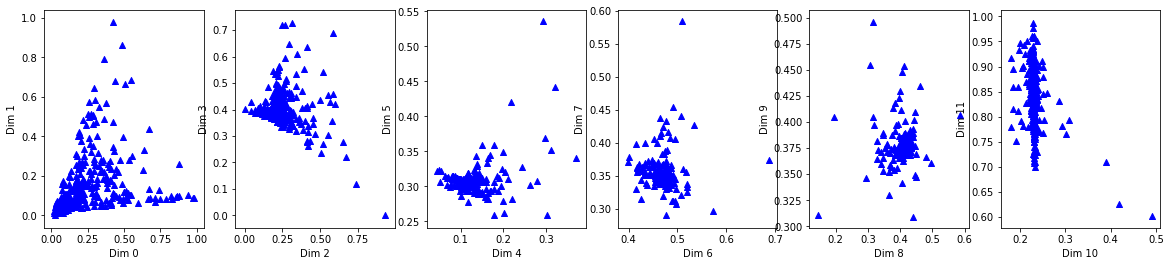

Plotting Electronic


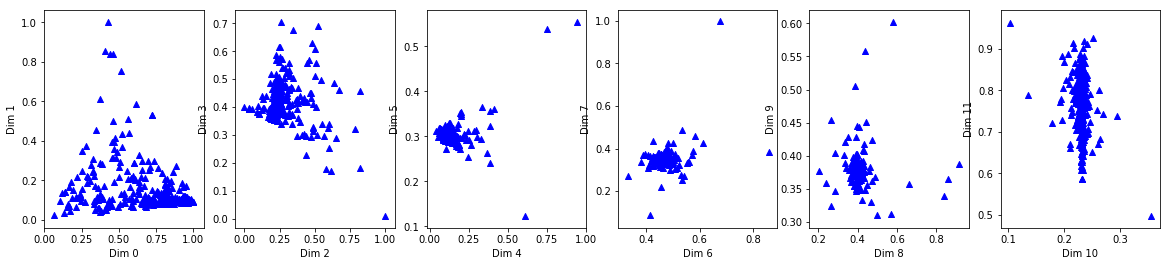

In [44]:
# Visualize 2 dimensions of the encodings for multiple segments in scatter plots

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

sample = np.arange(int(num_segments/10))
np.random.shuffle(sample)

for genre in [folk, electronic]:
    for i,idx in enumerate(genre.index):
        if i==0:
            print('Plotting {0}'.format(genre['track', 'genre_top'][idx]))
        toplot = range(0,encoding_shape[1],2)
        for i, dim in enumerate(toplot):
            dim1 = dim
            dim2 = dim+1
            if dim2 >= encoding_shape[1]:
                continue
            encoded = encodings[idx]
            x_ = np.transpose(encoded[sample, dim1])
            y_ = np.transpose(encoded[sample, dim2])
            plt.subplot(1,len(toplot), i+1)
            plt.xlabel('Dim {0}'.format(dim1))
            plt.ylabel('Dim {0}'.format(dim2))
            plt.scatter(x_, y_, marker='^', c='blue')
    plt.show()

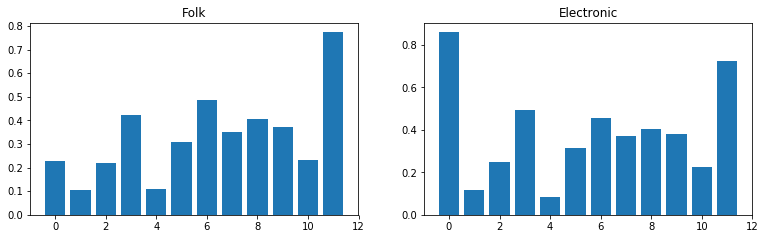

In [47]:
# Visualize encoings for random segment from multiple genres

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 12)

for i, genre in enumerate([folk, electronic]):
    # print(genre.shape)
    track_idx = genre.index[np.random.randint(genre.shape[0])]
    # print('Plotting {0} track {1}'.format(genre['track', 'genre_top'][track_idx], track_idx))
    encoding = encodings[track_idx]
    plt.subplot(3, 3, i+1)
    plt.title(genre['track', 'genre_top'][track_idx])
    plt.bar(np.arange(encoding.shape[1]), encoding[0,:])
plt.show()

Plotting Folk


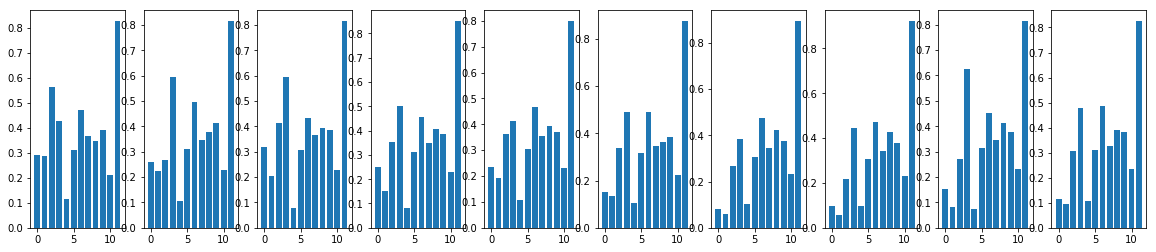

Plotting Electronic


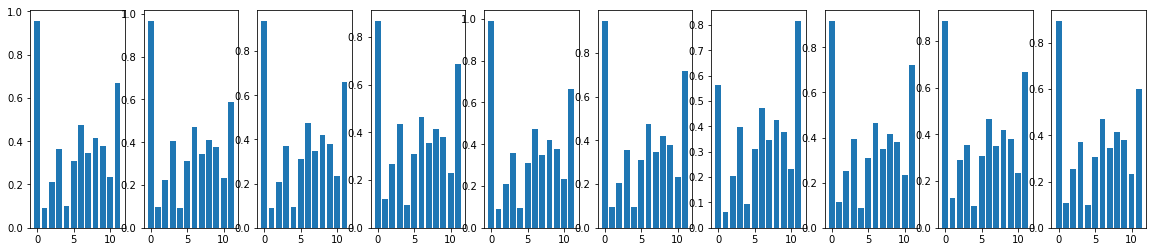

In [48]:
# Visualize the encodings of multiple segmets of the same track

import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (20, 4)

segments_to_visulize = 10

for genre in [folk,electronic]:
    track_idx = genre.index[np.random.randint(genre.shape[0])]
    print('Plotting {0}'.format(genre['track', 'genre_top'][track_idx]))
    encoding = encodings[track_idx]
    for i in range(segments_to_visulize):
        plt.subplot(1, segments_to_visulize, i+1)
        plt.bar(np.arange(encoding.shape[1]), encoding[i,:])
    plt.show()

array([9.3338785, 4.9311075], dtype=float32)